# Dynamical Systems

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
%config InlineBackend.figure_format = "retina"

In [3]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
def f(x, t):
    x, y = x
    ẋ = -(x + y)
    ẏ = 6 * x - y
    return ẋ, ẏ

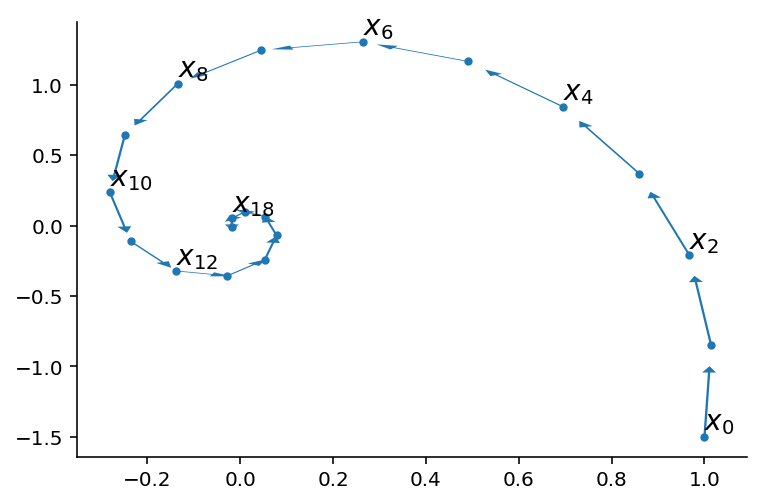

In [5]:
time = np.linspace(0, np.exp(3), 20)
time = np.exp(0.08163265) ** time
X = odeint(f, np.array([1.0, -1.5]), t=time)
plt.scatter(*X.T, s=10)

for i, (init, end) in enumerate(zip(X[:-1], X[1:])):
    Δx = end - init
    plt.arrow(*init, *Δx * 0.7, head_width=0.03, edgecolor="None", width=0.005)
    if i in [0, 2, 4, 6,8, 10, 12, 18]:
        plt.text(*init, "$x_{"f"{i}""}$", horizontalalignment="left",
                 verticalalignment="bottom",
                 fontsize=14)
# plt.savefig("../figures/discrete-dynamical-system.pdf")

## Coupled dynamical system

In [219]:
A = np.array([
    [-1, 1],
    [ -10, -1]
])

C = np.array([
    [-1, 0.4],
    [-1.5, -1]
])

In [418]:
def hidden_process(X, t, A, C):
    z = X[:2]
    ż = A @ z
    ẋ = C @ A @ z
    return np.concatenate((ż, ẋ))

def hidden_process(X, t, A, C):
    z = X[:2]
    z = np.concatenate((z, z))
    zeros = np.zeros((2, 2))
    M = np.r_[np.c_[A, zeros],
              np.c_[zeros, C @ A]]
    return M @ z

In [419]:
X0 = np.array([1.0, -1.5, 1.0, -1.5])
hidden_process(X0, time, A, C)

array([-2.5 , -8.5 , -0.9 , 12.25])

In [420]:
time = np.linspace(0, 3, 100)
steps = 20
time = np.linspace(0, np.exp(3), steps)
time =np.exp(0.08163265) ** time
X = odeint(hidden_process, X0, t=time, args=(A, C))

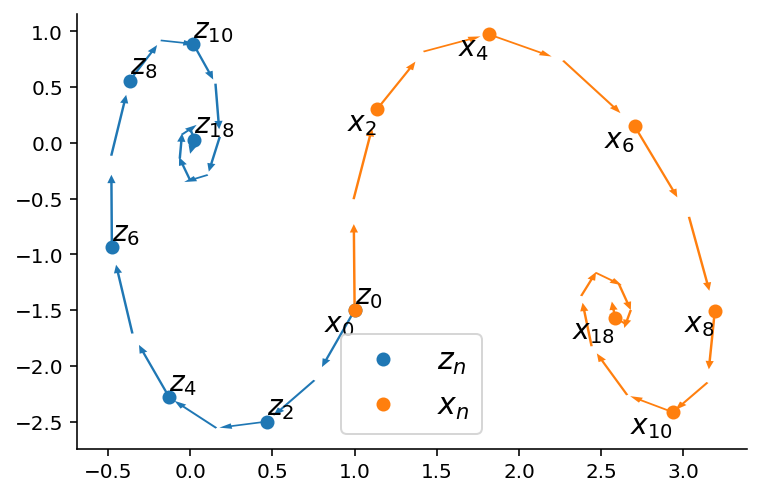

In [421]:
f1, f2 = plt.plot(*X[[0, 2, 4, 6,8, 10,18]].T, marker="o", linewidth=0)
plt.legend((f1, f2), ("$z_n$", "$x_n$"), fontsize=15)

for n in range(steps - 1):
    Z0, X0 = X[n, :2], X[n, 2:]
    Z1, X1 = X[n + 1, :2], X[n + 1, 2:]
    Δx = X1 - X0
    Δz = Z1 - Z0
    plt.arrow(*Z0, *Δz * 0.7, head_width=0.05, edgecolor="None", width=0.015)
    plt.arrow(*X0, *Δx * 0.7, head_width=0.05, edgecolor="None", width=0.015, facecolor="tab:orange")
    if n in [0, 2, 4, 6,8, 10,18]:
        plt.text(*Z0, "$z_{"f"{n}""}$", horizontalalignment="left",
                 verticalalignment="bottom",
                 fontsize=14)
        plt.text(*X0, "$x_{"f"{n}""}$", horizontalalignment="right",
                 verticalalignment="top",
                 fontsize=14)
# plt.savefig("../figures/hidden-dynamical-system.pdf")

## The Kalman-Bucy filtering process

In [517]:
A = np.array([
    [-1, 1],
    [ -10, -1]
])

C = np.array([
    [-1, 0.4],
    [-1.5, -1]
])

Γ = np.array([
    [0.4,  -0.8],
    [-0.5, 0.5]
])
Γ = Γ @ Γ.T / 20


Γ = np.eye(2) / 50
Σ = np.eye(2) / 100

muv = np.zeros(4)
zeros = np.zeros((2, 2))

cov_m = np.r_[np.c_[Γ, zeros],
              np.c_[zeros, Σ]]

z0 = np.array([1.0, -1.5])

In [518]:
def kalman_bucy(z0, A, C, Γ, Σ, n_sims, n_steps, T):
    # Initial variables
    dt = T / n_steps
    m, *_ = z0.shape
    zeros = np.zeros((m, m))
    M = np.r_[np.c_[A, zeros],
              np.c_[zeros, C @ A]]
    cov = np.r_[np.c_[Γ, zeros],
                np.c_[zeros, Σ]]
    W = multivariate_normal(cov=cov)
    vn = np.concatenate((z0, z0))    
    sol = np.zeros((2 * m, n_sims, n_steps))
    
    vn = np.concatenate((z0, z0))[..., None] * np.ones((2 * m, n_sims))
    for n in range(n_steps):
        dW = W.rvs(n_sims).T
        # vn + M * v + dW
        vhat_n = np.concatenate((vn[:2], vn[:2])) * np.ones((2 * m, n_sims))
        vn = vn + np.einsum("ij,js->is", M, vhat_n) * dt + dW * np.sqrt(dt)
        sol[:, :, n] = vn
    return sol

In [519]:
m = 2
vn = np.concatenate((z0, z0))[:, None] * np.ones((2 * m, n_sims))

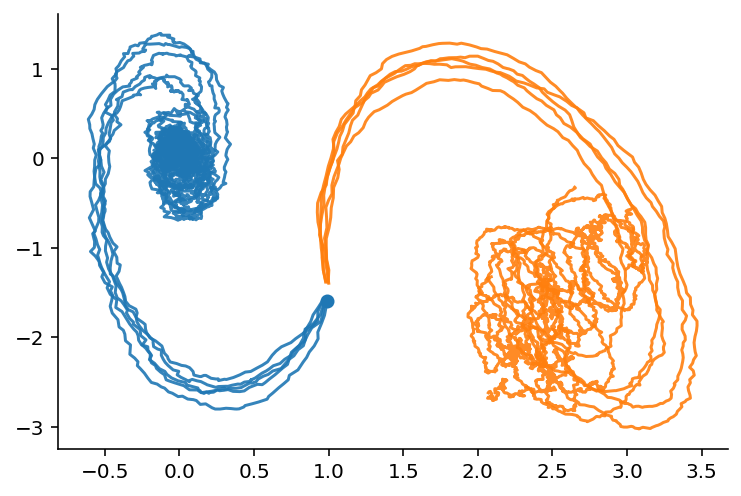

In [525]:
n_sims, n_steps = 5, 1000
T = 10
sol = kalman_bucy(z0, A, C, Γ, Σ, n_sims, n_steps, T)


plt.scatter(sol[0, 1, 0], sol[1, 1, 0])
for n in range(n_sims):
    plt.plot(sol[0, n, :], sol[1, n, :], c="tab:blue", alpha=0.9)
    plt.plot(sol[2, n, :], sol[3, n, :], c="tab:orange", alpha=0.9)